# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.022133,False,-2.807938
1,1.910251,True,8.002341
2,-0.950440,False,-0.737355
3,1.002854,True,7.391311
4,0.313097,False,0.241392
...,...,...,...
995,0.858785,True,6.046750
996,-2.289124,False,-4.572886
997,1.535708,True,7.733274
998,-1.522603,False,-2.224942


<AxesSubplot: xlabel='v0'>

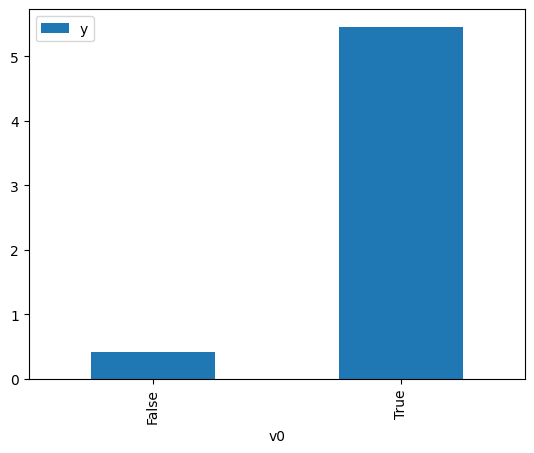

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

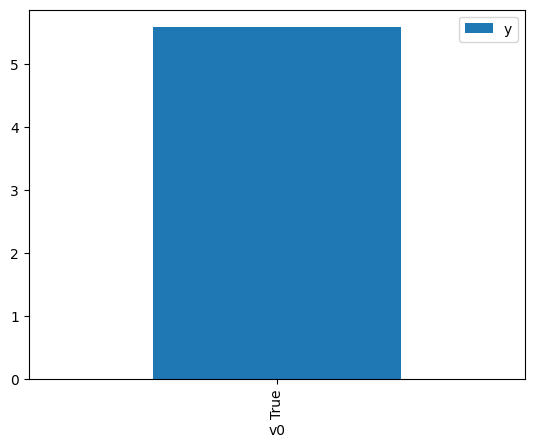

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.047703,False,-2.415828,0.751742,1.330244
1,-1.724963,False,-2.344152,0.871566,1.147360
2,-0.581874,False,-0.405660,0.634806,1.575284
3,-1.049929,False,-1.634423,0.752236,1.329369
4,-0.714619,False,-2.909711,0.670634,1.491125
...,...,...,...,...,...
995,0.696633,False,0.230988,0.274792,3.639116
996,2.047079,False,5.353177,0.070470,14.190451
997,0.710578,False,1.868756,0.271493,3.683333
998,-1.501589,False,-1.671420,0.838719,1.192295


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.224450,True,3.947551,0.468287,2.135442
1,-0.970893,True,1.012214,0.265728,3.763242
2,-2.597438,True,-0.455391,0.049528,20.190702
3,0.085176,True,6.946329,0.560181,1.785138
4,0.112593,True,5.026265,0.568213,1.759904
...,...,...,...,...,...
995,-0.733617,True,5.623811,0.324385,3.082757
996,1.466482,True,7.483716,0.868495,1.151417
997,1.282823,True,6.986208,0.841427,1.188457
998,1.160538,True,6.755879,0.821007,1.218017


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.319e+04
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                        0.00
Time:                        16:56:01   Log-Likelihood:                         -1424.3
No. Observations:                1000   AIC:                                      2853.
Df Residuals:                     998   BIC:                                      2862.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0192      0.035     56.887      0.000       1.950       2.089
x2             4.9670      0.047    104.646      0.000       4.874       5.060
==============================================================================
Omnibus:                        2.898   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.931
Skew:                          -0.110   Prob(JB):                        0.231
Kurtosis:                       2.851   Cond. No.                         1.85
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""